# Problema MNIST

## O Problema MNIST e a Solução com InceptionV3
### Introdução
Como programador de deep learning, minha tarefa é resolver problemas complexos de reconhecimento de padrões e imagens. Vou explicar o problema do MNIST e como podemos resolvê-lo utilizando o modelo InceptionV3.

### O Problema MNIST
O conjunto de dados MNIST (Modified National Institute of Standards and Technology) é um benchmark clássico no campo de aprendizado de máquina. Ele consiste em 60.000 imagens de treino e 10.000 imagens de teste de dígitos manuscritos (0-9), cada uma em uma matriz de 28x28 pixels. O objetivo é classificar corretamente esses dígitos com um modelo de reconhecimento de padrões. Este problema é comumente utilizado para testar e comparar a eficácia de diferentes algoritmos de aprendizado de máquina.

https://yann.lecun.com/exdb/mnist/

### Descrição do Modelo InceptionV3
O InceptionV3 é uma arquitetura de rede neural convolucional avançada desenvolvida pelo Google. Ele é conhecido por sua eficiência e precisão em tarefas de classificação de imagens. O modelo é composto por vários blocos de camadas convolucionais que permitem a extração de características a diferentes escalas, tornando-o robusto para a detecção de padrões complexos.

https://keras.io/api/applications/inceptionv3/

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [2]:
transform = transforms.ToTensor() # definindo a conversão de imagem para tensor

trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) # Carrega a parte de treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes

valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform) # Carrega a parte de validação do dataset
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes

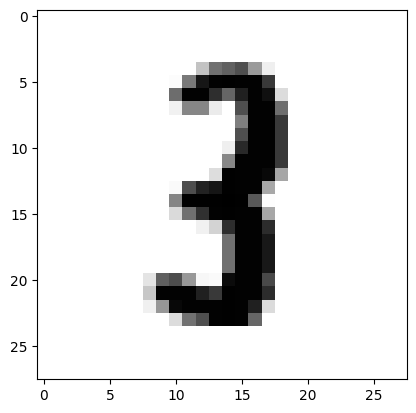

In [3]:
# Conferindo se a estrutura de dados está representando a imagem corretamente

dataiter = iter(trainloader)
imagens, etiquetas = next(dataiter)
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r')


In [4]:
# Verificaras dimensões do tensor para img e etiqueta

print(imagens[0].shape)
print(etiquetas[0].shape)

torch.Size([1, 28, 28])
torch.Size([])


In [5]:
# Estrutura da rede InceptionV3 - Keras

class Modelo(nn.Module):

  def __init__(self):
    super(Modelo, self).__init__()
    self.linear1 = nn.Linear(28*28, 128) # layer de entrada, 784 neurônios que se ligam a 128
    self.linear2 = nn.Linear(128, 64) # layer intermédio, 128 neurônios que se ligam a 64
    self.linear3 = nn.Linear(64, 10) # layer de saída, 64 neurônios que se ligam a 10
    # para a camada de saída não é necessário definir nada pois só precisamos pegar o output da camada interna 2

  def forward(self, X):
    X = F.relu(self.linear1(X)) # função de ativação ReLU da camada de entrada para a camada interna 1
    X = F.relu(self.linear2(X)) # função de ativação ReLU da camada interna 1 para a camada interna 2
    X = self.linear3(X) # Não precisamos de uma função de ativação na camada de saída pois ela é uma regressão linear
    return F.log_softmax(X, dim=1) # aplica a função de log_softmax para calcular a perda

In [6]:
# Otimizador
def treino(modelo, trainloader, device):

  otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) # otimizador estocástico gradiente, define a política de atualizaação dos pesos e da bias
  inicio = time() # marca o tempo de início do treinamento

  criterio = nn.NLLLoss() # função de perda
  EPOCHS = 10 # número de epochs que o algoritmo rodará
  modelo.train() # ativando o modo de treinamento do modelo

  for epoch in range(EPOCHS):
    perda_acumulada = 0 # variável para acumular a perda

    for imagens, etiquetas in trainloader:

      imagens = imagens.view(imagens.shape[0], -1) # redimensionando as imagens, convertendo as imagens para "vetores" de 28*28 casas ficarem compatíveis
      otimizador.zero_grad() # zerando os gradientes por conta do ciclo anterior

      output = modelo(imagens.to(device)) # passando as imagens para o modelo
      perda_instantanea = criterio(output, etiquetas.to(device)) # calculando a perda do epoch em questão

      perda_instantanea.backward() # fazendo a backpropagation a partir da perda

      otimizador.step() # atualizando os pesos e bias

      perda_acumulada += perda_instantanea.item() # atualizando a perda acumulada

    else:
      print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))

  print("\nTempo de treino (em minutos) =",(time()-inicio)/60)

In [7]:
# Realizando a validação

def validacao(modelo, valloader, device):
  conta_corretas, conta_todas = 0, 0
  for imagens, etiquetas in valloader:
    for i in range(len(etiquetas)):
      img = imagens[i].view(1, 784)
      # desativar o auto_grad para acelerar a validação. Grafos computacionais dinâmicos tem um custo alto de processamento
      with torch.no_grad():
        logps = modelo(img.to(device)) # saída do modelo em escala logarítmica

      ps = torch.exp(logps) # converte a saída do modelo em escala linear
      probab = list(ps.cpu().numpy()[0])
      etiqueta_pred = probab.index(max(probab)) # converte o tensor em um número, no caso, o número que o modelo previu como correto
      etiqueta_certa = etiquetas.numpy()[i]
      if(etiqueta_certa == etiqueta_pred): # compara a previsão com o valor correto
        conta_corretas += 1
      conta_todas += 1

  print("Total de imagens testadas =", conta_todas)
  print("\nPrecisão do modelo = {}%".format(conta_corretas*100/conta_todas))

In [8]:
# Leitura do modelo

modelo = Modelo()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)